In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import urllib.request
import warnings 
warnings.simplefilter('ignore')
import plotly.express as px
%matplotlib inline

In [77]:
# Display format
pd.set_option('display.float_format', lambda x: '%.4f' % x)

### QA section

In [78]:
tazs_to_ignore_2000021 = [1403,1407,1408,1409,1410,1411,1412,1413,1415,1416,1417,1418,1419, 1107]

In [79]:
tazs_to_ignore_2000002 = [1046,1048,1049,1050,1051,1072,1073, 1075, 1076,1077,1078,1079]

In [80]:
tazs_to_ignore_2000003 = [1067,1068,1069,1074,1086,1081]

In [81]:
tazs_to_ignore_2000019 = [1380, 1381]

### Importing and cleaning of Idan.S mapping


In [82]:
# reading_idans_mapping
def reading_idans_mapping():
    idans_mapping = pd.read_csv(r'/Users/yotamdery/Old Desktop/git/health_data_mapping/From_Idan_Shachmon/overlap_taz2stat.csv', index_col= False, usecols= ['taz_id','yesh_id','stat11_id','prc'] )
    idans_mapping['taz_id'] = idans_mapping['taz_id'].astype(int)
    idans_mapping = idans_mapping.loc[idans_mapping.prc > 0.0001]
    return idans_mapping

In [83]:
#Replacing the "1" values with "0" for towns with only blank in agas_code:
def replace_1_with_0(temp_df):
    if temp_df.shape[0] == temp_df['stat11_id'].sum():
        temp_df['stat11_id'] = temp_df['stat11_id'].replace(to_replace = 1, value = 0)
    return temp_df

In [84]:
# Normalizing the prc for each statistical areas (There are areas which cover a lot of Tazs completely, like (2610,38))
# Work permise is that statistical area cant be bigger than Taz, So 1 stat. area can't cover a lot of Tazs
def norm_prc_stat_area(df):
    if df['prc'].sum() > 6:
        prc_sum = np.sum(df['prc'])
        df['normalized_prc'] = df['prc'] / prc_sum
    else:
        df['normalized_prc'] = df['prc']
    
    df['prc'] = df['normalized_prc']
    df = df.drop('normalized_prc', axis = 1)
    return df
    

In [85]:
# idans_mapping = idans_mapping.groupby(by= ['yesh_id', 'stat11_id'], as_index= False).apply(norm_prc_stat_area)

In [86]:
# idans_mapping['prc'] = idans_mapping['normalized_prc']
# idans_mapping = idans_mapping.drop('normalized_prc', axis = 1)

In [87]:
# # Normalizing the prc for each Taz - forcing the sum of the prc for each Taz to be 1
# def norm_prc_taz(df):
#     if df['prc'].sum() > 0:
#         prc_sum = np.sum(df['prc'])
#         df['normalized_prc'] = df['prc'] / prc_sum
#     else:
#         df['normalized_prc'] = df['prc']
#     return df
    

In [88]:
# idans_mapping = idans_mapping.groupby(by= ['taz_id']).apply(norm_prc_taz).reset_index()

In [89]:
# idans_mapping['prc'] = idans_mapping['normalized_prc']
# idans_mapping = idans_mapping.drop(labels= ['normalized_prc', 'index'], axis = 1)

In [90]:
# Accessing the API
url = 'https://data.gov.il/api/3/action/datastore_search?resource_id=d07c0771-01a8-43b2-96cc-c6154e7fa9bd&limit=1000000'  
fileobj = urllib.request.urlopen(url)
df = pd.read_json(fileobj)
data = df.loc['records']['result']

In [91]:
sick = pd.DataFrame(data)

In [92]:
# Taking the relevant columns
sick = sick [['town_code', 'agas_code', 'town', 'date', 'accumulated_vaccination_first_dose', 'accumulated_vaccination_second_dose']]

In [93]:
sick['agas_code'].fillna(value= '0', inplace= True)

In [94]:
# filtering the df
def filtering_rows(df):
    for c in df.columns:
        if c in ['accumulated_vaccination_first_dose', 'accumulated_vaccination_second_dose']:  
            sick_filtered = df[(df[c] != '0.0') & (df[c] != '<15')]
    return sick_filtered

In [95]:
# Type convertion of fields
def types_convertion(df):
    df['date'] = pd.to_datetime(df['date'])
    for c in df.columns:
        if c in ['accumulated_vaccination_first_dose', 'accumulated_vaccination_second_dose']:    # Have to convert to float first because of the original format...
            df[c] = df[c].astype(float)
        if c not in ['date','town']:                 # Converting all columns but the date column
            df[c] = df[c].astype(int)
    return df

### Spread the health data of the blank agas codes to all other stat. areas -

<b> Spreading the Vaccinated individuals  from the blank agas code to the other stat. areas, Uniformly:

In [96]:
def spreading_agas_blank(df):
    if 0 in list(df['agas_code']):         
        # Defining the addition of each field
        vaccinated_addition = (df[df['agas_code'] == 0][df.columns[-1]].iloc[0]) / df.shape[0]-1  # The amount of vaccinated to spread for each row
        
        # Updating the fields - according to the proportion of the active cases!
        if len(df['agas_code']) == 1:
            return df
        else:
            df[df.columns[-1]] = (df[df.columns[-1]]) + vaccinated_addition            
            df = df.loc[df['agas_code'] != 0]     # eliminating agas code blank

    return df

<b> spreading the vaccinated individuals over the Tazs:

In [97]:
### df.columns[4] == The dose feature (whether it's first or second dose)
def norm_by_prc(df):
    df[df.columns[4] + '_norm'] = df[df.columns[4]] * df['prc']
    return df   

In [98]:
# Removing outliers for beit shemesh and jerusalem
def tazs_to_ignore(df):
    tazs_to_ignore_2000021 = [1403,1407,1408,1409,1410,1411,1412,1413,1415,1416,1417,1418,1419, 1107]
    tazs_to_ignore_2000002 = [1046,1048,1049,1050,1051,1072,1073, 1075, 1076,1077,1078,1079]
    df = df.loc[~df['taz_id'].isin(tazs_to_ignore_2000021)]
    df = df.loc[~df['taz_id'].isin(tazs_to_ignore_2000002)]
    return df

In [99]:
# A mapper - taz for 250 regions 
def reading_taz_250_mapping():
    taz_250_mapping = pd.read_excel(r'/Users/yotamdery/Old Desktop/git/health_data_mapping/Taz_Yeshuv_250_mapping.xlsx',engine='openpyxl', usecols= "A,P,AH")
    taz_250_mapping = taz_250_mapping.rename(columns= {'Unnamed: 0' : 'taz_id', 'Unnamed: 15' : 'population', 'Unnamed: 33' : '250_regions'})
    taz_250_mapping = taz_250_mapping.loc[3:2632]
    return taz_250_mapping

In [100]:
# Mappers - Total population for 250 regions and Taz for 250_regions
def create_mappers():
    taz_to_250_mapper = reading_taz_250_mapping()[['taz_id','250_regions']]
    pop_for_250_mapper = reading_taz_250_mapping()[['population','250_regions']]
    pop_for_250_mapper = pop_for_250_mapper.groupby('250_regions', as_index= False).sum()
    return taz_to_250_mapper, pop_for_250_mapper


In [101]:
def reading_250_30_mapping():
    mapping_30_250 = pd.read_excel(r'/Users/yotamdery/Old Desktop/git/Covid_data_investigation/cell250_to_cell30.xlsx',engine='openpyxl')
    return mapping_30_250

In [102]:
def reading_religion_dest_30():
    religion_30 = pd.read_csv(r'/Users/yotamdery/Old Desktop/git/Covid_data_investigation/religion_destribution_30_counties.csv')
    return religion_30

In [103]:
# Receives the recent DF and a mapper from 250 to 30
def aggregate_to_30_level(vaccinated_with_pop_250, mapping_30_250):
    vaccinated_30_merged = vaccinated_with_pop_250.merge(mapping_30_250, left_on= '250_regions', right_on= 'cell_id')
    vaccinated_30_no_pop = vaccinated_30_merged.groupby(by= ['30_county','date'], as_index= False)[vaccinated_30_merged.columns[2]].sum()      # Aggregate health data to county level
    
    vaccinated_30_merged_no_duplicates = vaccinated_30_merged[~vaccinated_30_merged.duplicated(subset= ['250_regions','population'])]
    pop_30_mapper = vaccinated_30_merged_no_duplicates.groupby('30_county', as_index= False)['population'].sum()                                                # Aggregate the *population* to county level
    vaccinated_30_with_pop = vaccinated_30_no_pop.merge(pop_30_mapper, on= '30_county')
    
    vaccinated_30_with_pop['30_county'] = vaccinated_30_with_pop['30_county'].astype(str)
    return vaccinated_30_with_pop
    

In [104]:
# Calculating the absolute values of vaccinations - creating a new column for it
def calculate_difference_vaccinations(df):
    df['absolute_' + df.columns[-2][12:]] = df[df.columns[-2]].diff()
    return df

In [112]:
# Main function - Receiving only the health df
def main(df):
    df = df.copy()
    sick_filtered = filtering_rows(df)     # Removing categorical values (rows with '0' and '<15')    
    df_types_converted = types_convertion(sick_filtered)          # Converting the types
    sorted_df = df_types_converted.sort_values(by= ['town_code', 'date'])    # Sorting the df
    vaccinated_spreaded_df = sorted_df.groupby(by= ['town_code', 'date'], as_index= False).apply(spreading_agas_blank)    # spreading the blank agas
    vaccinated_spreaded_df = vaccinated_spreaded_df.reset_index().drop(labels= ['level_0', 'level_1'], axis = 1)          # Re-indexing
    # Sanity check:
    print("Total number of {}:".format(vaccinated_spreaded_df.columns[-1][12:]))
    print(vaccinated_spreaded_df[vaccinated_spreaded_df['date'] == vaccinated_spreaded_df['date'].max()][vaccinated_spreaded_df.columns[-1]].sum())
    
    ### Merging the health file with idans mapping - To get the TAZ for each stat. area:
    idans_mapping = reading_idans_mapping()
    idans_mapping = idans_mapping.groupby(by= 'yesh_id').apply(replace_1_with_0)                  #Replacing the "1" values with "0" for towns with only blank in agas_code:
    idans_mapping = idans_mapping.groupby(by= ['yesh_id', 'stat11_id'], as_index= False).apply(norm_prc_stat_area)

    vaccinated_and_idans_mapping = vaccinated_spreaded_df.merge(idans_mapping, how= 'inner', left_on = ['town_code', 'agas_code'], right_on = ['yesh_id', 'stat11_id'])
    ## Spreading over the Tazs:
    vaccinated_and_idans_mapping = vaccinated_and_idans_mapping.groupby(by= ['taz_id']).apply(norm_by_prc)
    # Summing to get the data on Taz level:
    grouped_vaccinated_and_mapping = vaccinated_and_idans_mapping.groupby(by= ['taz_id','date'])[vaccinated_and_idans_mapping.columns[-1]].sum().reset_index()
    grouped_vaccinated_and_mapping.rename(columns= {grouped_vaccinated_and_mapping.columns[2] : grouped_vaccinated_and_mapping.columns[2][:-5]}, inplace= True)
    vaccinated_by_taz = tazs_to_ignore(grouped_vaccinated_and_mapping)                  # Removing outliers for beit shemesh and jerusalem
    # Sanity check:
    print("Total number of {}:".format(vaccinated_by_taz.columns[2][12:]))
    print(vaccinated_by_taz[vaccinated_by_taz['date'] == vaccinated_by_taz['date'].max()][vaccinated_by_taz.columns[-1]].sum())

    taz_250_mapping, pop_for_250_mapper = create_mappers()                                # Mappers - Total population for 250 regions and Taz for 250_regions
    vaccinated_250_merged = vaccinated_by_taz.merge(taz_250_mapping)
    vaccinated_250 = vaccinated_250_merged.groupby(by= ['250_regions', 'date'], as_index= False).sum()    # Aggregating to 250 regions level
    vaccinated_with_pop_250 = vaccinated_250.merge(pop_for_250_mapper)                                  # envolving the population for each region
    
    mapping_30_250 = reading_250_30_mapping()                               # reading the 250 to 30 counties file
    vaccinated_30_with_pop = aggregate_to_30_level(vaccinated_with_pop_250, mapping_30_250)        # Aggregating the data to 30 counties level
        
    absolute_vaccination_amount = vaccinated_30_with_pop.groupby(by= ['30_county'], as_index= False).apply(calculate_difference_vaccinations)    # Calculating the actual amounts of vaccinations
    absolute_vaccination_amount = absolute_vaccination_amount[~absolute_vaccination_amount[absolute_vaccination_amount.columns[-1]].isna()]                          # Removing the first row (the start of documentation date)
        
    religion_30 = reading_religion_dest_30()
    result = absolute_vaccination_amount.merge(religion_30)
    return result
    

In [113]:
df_first_dose = main(sick.copy().drop('accumulated_vaccination_second_dose',axis= 1))
print("\nFinished creating first dose\n")

df_second_dose = main(sick.copy().drop('accumulated_vaccination_first_dose',axis= 1))
print("\nFinished creating second dose df\n")

Total number of vaccination_first_dose:
4580640.777252291
Total number of vaccination_first_dose:
4483473.379389611

Finished creating first dose

Total number of vaccination_second_dose:
4268711.341274673
Total number of vaccination_second_dose:
4180551.7311960775

Finished creating second dose df



### Results:

In [115]:
df_first_dose.to_csv("df_first_dose.csv", index= False)
df_second_dose.to_csv("df_second_dose.csv", index= False)

In [3]:
df_first_dose = pd.read_csv(r'df_first_dose.csv')
df_second_dose = pd.read_csv(r'df_second_dose.csv')

In [118]:
n_steps = 2
def my_fun(x):
    return x.iloc[-1] - x.iloc[0]

test = df_first_dose.loc[df_first_dose['30_county'] == 11].rolling(window= n_steps).apply(my_fun)

In [119]:
(test < 0).sum()

30_county                             0
date                                  0
accumulated_vaccination_first_dose    0
population                            0
absolute_vaccination_first_dose       0
Orthodox                              0
Generall                              0
Arabs                                 0
dtype: int64

# Plots:

<b> Plotting # of first dose vaccinations (devided by population) over time 

In [134]:
# Adding the feature
df_first_dose['vaccinated_per_pop(%)'] = (df_first_dose['absolute_vaccination_first_dose'] / df_first_dose['population']) * 100

In [136]:
plot_df = df_first_dose.pivot(index= ['date'], columns= '30_county', values= 'vaccinated_per_pop(%)')

In [138]:
# Different counties have different starting date of vaccinations
plot_df.fillna(value= 0, inplace= True)

<b> Defining the function for the plots

In [139]:
# Defining the function for the plots
def plot_generall_haredim_arabs(df_to_plot):
    fig, ax = plt.subplots(figsize= (20,11))
    ax.set_xlabel('Time [d]', fontsize= 25)
    ax.set_ylabel('(%) of vaccinations per pop.', fontsize=25)
    ax.set_title('(%) of first dose vaccinations (devided by population) over time', fontsize=30)
    df_to_plot.plot(ax= ax)

<b> Plotting TLV Vs. B'ney B'rak

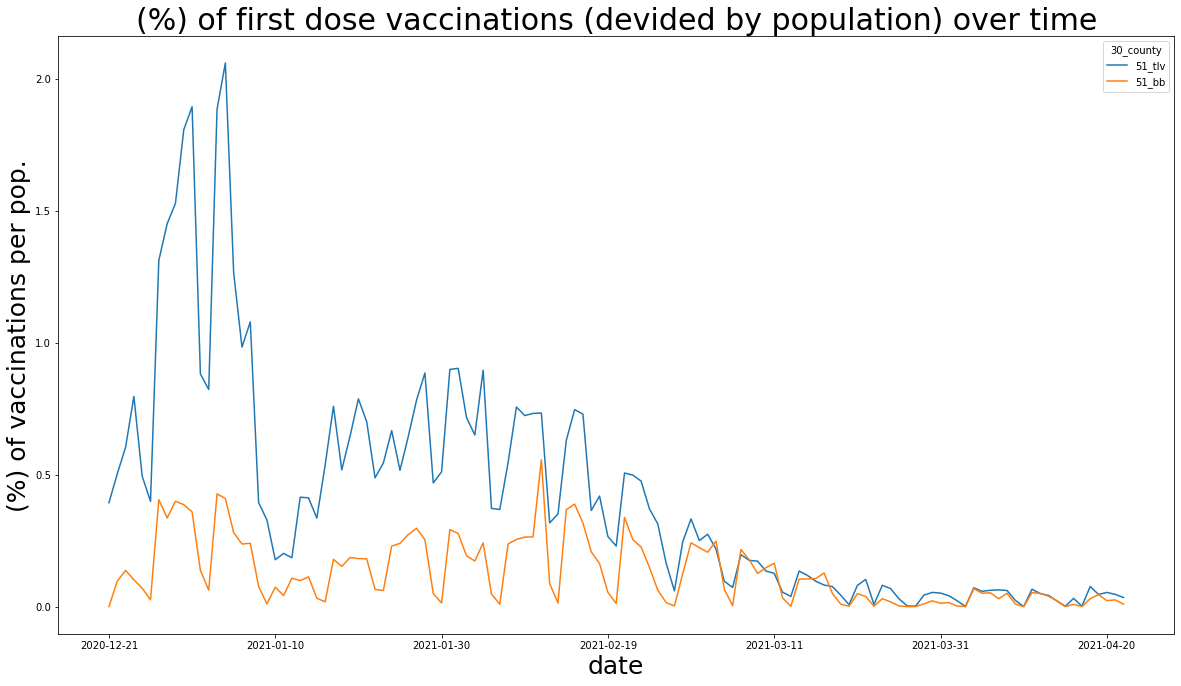

In [140]:
plot_generall_haredim_arabs(plot_df[['51_tlv', '51_bb']])

<b> Plotting 11_haredi Vs. 11_betshemesh

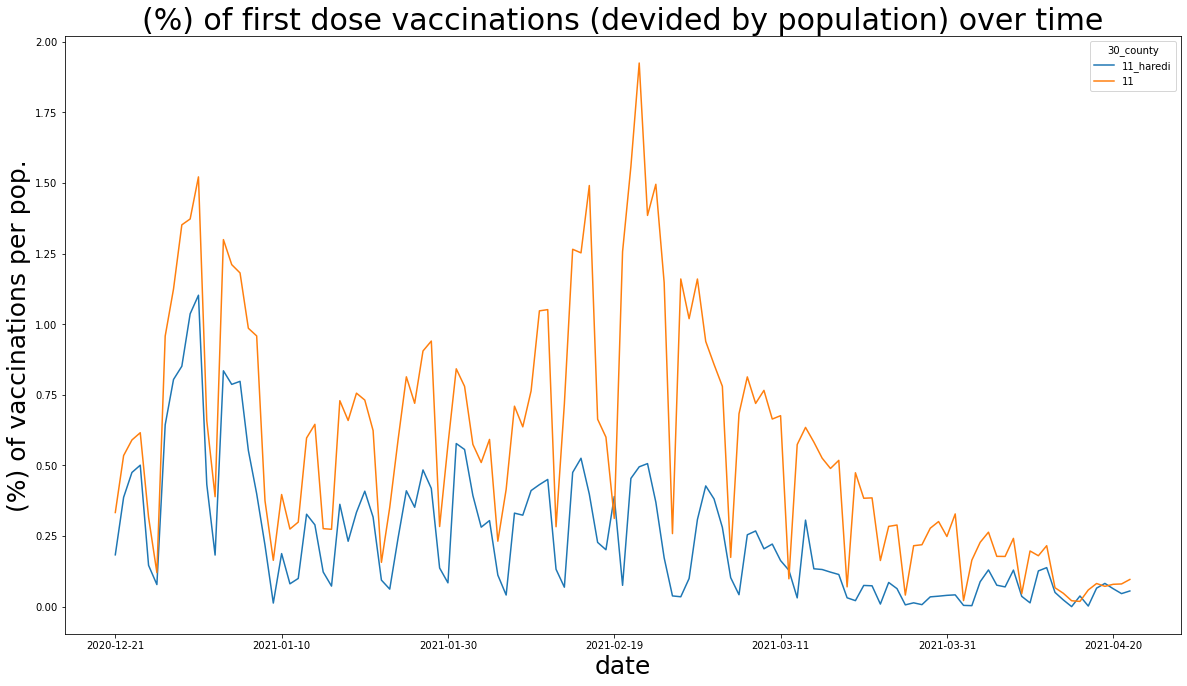

In [150]:
plot_generall_haredim_arabs(plot_df[['11_haredi', '11']])

<b> Plotting 42_arab Vs. 42_haredi Vs. 42_secular

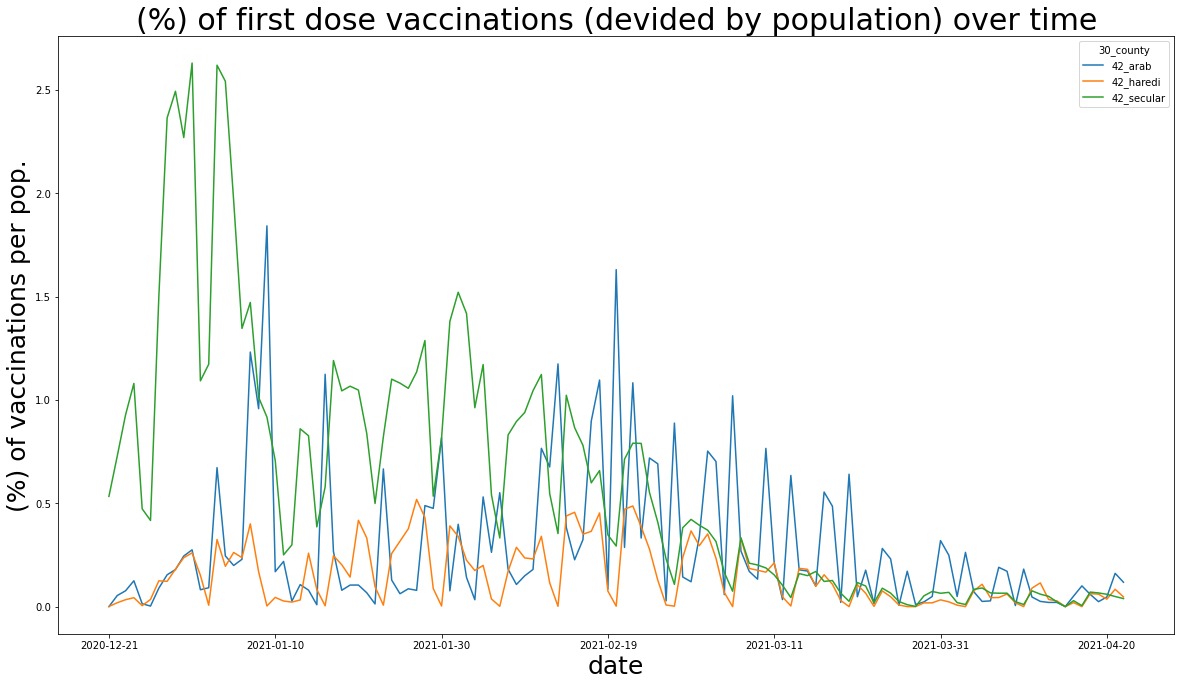

In [144]:
plot_generall_haredim_arabs(plot_df[['42_arab', '42_haredi', '42_secular']])

<b> Plotting the top 3 regions (with the highest vaccinations per population precentage)

In [253]:
transposed_plot_df = plot_df.T

In [254]:
transposed_plot_df['mean'] = transposed_plot_df.mean(axis= 1)

In [255]:
top_3_df = transposed_plot_df.sort_values(by= 'mean', ascending= False).iloc[0:3]

In [257]:
top_3_df_to_plot = top_3_df.drop('mean', axis= 1).T

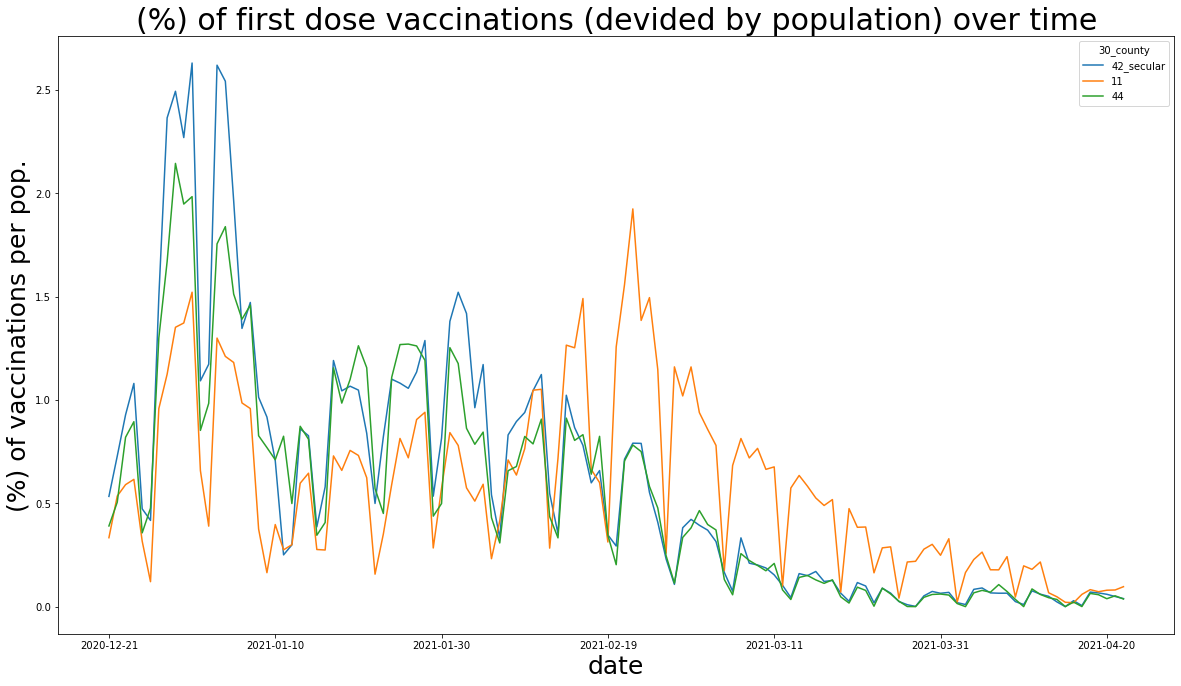

In [259]:
plot_generall_haredim_arabs(top_3_df_to_plot)

<b> Plotting the top county Vs. bottom county (with the highest/lowest vaccinations per population precentage)

In [264]:
top_county = transposed_plot_df.sort_values(by= 'mean', ascending= False).iloc[0].to_frame()
bottom_county = transposed_plot_df.sort_values(by= 'mean', ascending= False).iloc[-1].to_frame()

In [267]:
concatenated_df = pd.concat([top_county, bottom_county], axis= 1)

In [271]:
highest_lowest_df_to_plot = concatenated_df.drop('mean', axis= 0)

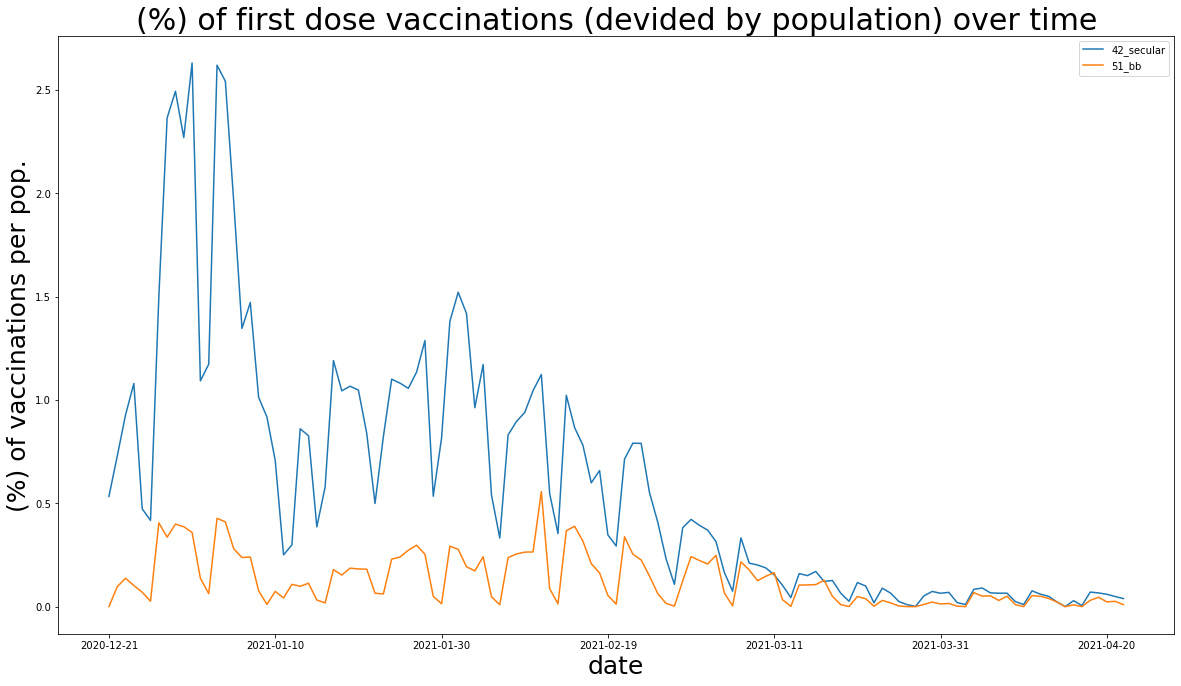

In [273]:
plot_generall_haredim_arabs(highest_lowest_df_to_plot)

<b> Trying to aggregate to haredim - arabs - generall level: <br>
    <b> trying to add a new feature and than group-by it:
    

In [172]:
def add_main_religion_feature(df):
    if df['Generall'].iloc[0] > 0.5:
        df['main_religion'] = 'Generall'
    elif df['Orthodox'].iloc[0] > 0.5:
        df['main_religion'] = 'Orthodox'
    else:
        df['main_religion'] = 'Arabs'
    return df

In [173]:
# Adding the new feature
df_first_dose = df_first_dose.groupby('30_county').apply(add_main_religion_feature)

In [197]:
# aggregating the vaccines and the population separatly
religion_grouped_df = df_first_dose.groupby(by= ['main_religion', 'date'])[['absolute_vaccination_first_dose']].sum().reset_index()
no_dup_df = df_first_dose[~df_first_dose.duplicated(subset= ['30_county', 'population'])]
religion_population_mapper = no_dup_df.groupby(by= ['main_religion'])[['population']].sum().reset_index()

In [202]:
# Merging
religion_df = religion_grouped_df.merge(religion_population_mapper)

In [207]:
religion_df['vaccinated_per_pop(%)'] = (religion_df['absolute_vaccination_first_dose'] / religion_df['population']) * 100

In [208]:
religion_df

,main_religion,date,absolute_vaccination_first_dose,population,vaccinated_per_pop(%)
0,Arabs,2020-12-21,79.1990,921333.0000,0.0086
1,Arabs,2020-12-22,1546.9073,921333.0000,0.1679
2,Arabs,2020-12-23,1917.5992,921333.0000,0.2081
3,Arabs,2020-12-24,1923.0063,921333.0000,0.2087
4,Arabs,2020-12-25,1378.8311,921333.0000,0.1497
...,...,...,...,...,...
364,Orthodox,2021-04-18,159.7088,349649.0000,0.0457
365,Orthodox,2021-04-19,178.0547,349649.0000,0.0509
366,Orthodox,2021-04-20,208.0425,349649.0000,0.0595
367,Orthodox,2021-04-21,112.5610,349649.0000,0.0322


In [210]:
pivoted_df = religion_df.pivot(index= 'date', columns= 'main_religion', values= 'vaccinated_per_pop(%)')

In [211]:
pivoted_df

main_religion,Arabs,Generall,Orthodox
date,,,
2020-12-21,0.0086,0.2774,0.0052
2020-12-22,0.1679,0.4868,0.0657
2020-12-23,0.2081,0.6783,0.1071
2020-12-24,0.2087,0.7757,0.0870
2020-12-25,0.1497,0.3914,0.0550
...,...,...,...
2021-04-18,0.0632,0.0623,0.0457
2021-04-19,0.0573,0.0570,0.0509
2021-04-20,0.0592,0.0503,0.0595


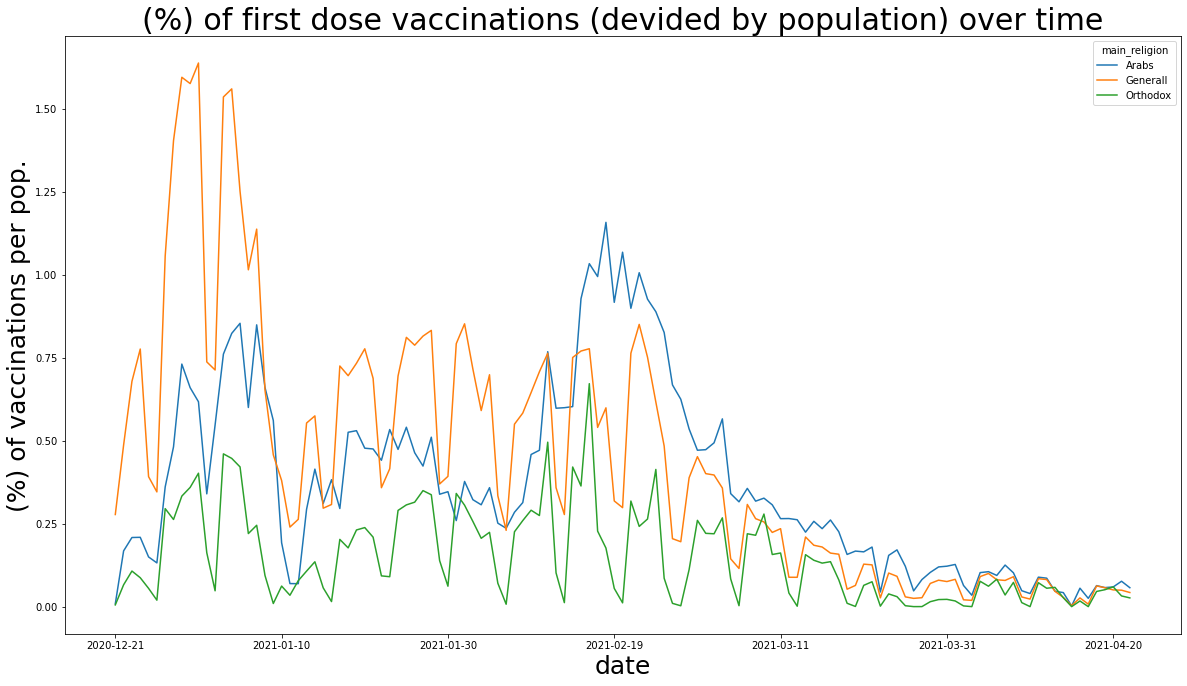

In [212]:
plot_generall_haredim_arabs(pivoted_df)